# 0. Setting Up The Env

## 0.1 Packages

In [1]:
from pathlib import Path

In [2]:
import numpy as np
import pandas as pd

import itertools


In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

## 0.2 Utilities

In [6]:
def plot_distributions(df, target_col):
    for col in df.columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            continue

        plt.figure(figsize=(3, 3))
        sns.kdeplot(
            data=df, x=col, hue=target_col,
            common_norm=False, fill=True, alpha=0.4
        )
        plt.title(f"Distribution of {col} by {target_col}")
        plt.show()  

In [7]:
def cap_to_99(df):
    df_capped = df.copy()
    for col in df_capped.columns:
        cap_value = df_capped[col].quantile(0.99)
        df_capped[col] = df_capped[col].clip(upper=cap_value)
    return df_capped


## 0.3 Constants

In [8]:
project_root = Path.cwd().parent
project_root

WindowsPath('d:/01 Work/06-Segmentations')

In [9]:
processed_file_path = f"{project_root}/data/processed/preprocessed_bank.csv"

processed_file_path

'd:\\01 Work\\06-Segmentations/data/processed/preprocessed_bank.csv'

In [10]:
capped_file_path = f"{project_root}/data/processed/capped.csv"
target_file_path = f"{project_root}/data/processed/target.csv"
capped_file_path, target_file_path

('d:\\01 Work\\06-Segmentations/data/processed/capped.csv',
 'd:\\01 Work\\06-Segmentations/data/processed/target.csv')

# 1. The Data

In [11]:
data_df  = pd.read_csv(processed_file_path)
print(f"The data has {data_df.shape[0]} rows and {data_df.shape[1]} columns")
print("Data Preview:")
data_df.head()

The data has 45211 rows and 34 columns
Data Preview:


,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,marital_married,marital_single,education_primary,education_secondary,education_tertiary,contact_cellular,contact_unknown,poutcome_failure,poutcome_other,poutcome_unknown
0,58,0,2143,1,0,5,261,1,-1,0,...,1,0,0,0,1,0,1,0,0,1
1,44,0,29,1,0,5,151,1,-1,0,...,0,1,0,1,0,0,1,0,0,1
2,33,0,2,1,1,5,76,1,-1,0,...,1,0,0,1,0,0,1,0,0,1
3,47,0,1506,1,0,5,92,1,-1,0,...,1,0,0,0,0,0,1,0,0,1
4,33,0,1,0,0,5,198,1,-1,0,...,0,1,0,0,0,0,1,0,0,1


In [12]:
data_df.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'previous', 'y', 'sin_month', 'cos_month',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'contact_cellular', 'contact_unknown',
       'poutcome_failure', 'poutcome_other', 'poutcome_unknown'],
      dtype='object')

# 2. Outlier Analysis

In [13]:
X = data_df.drop("y", axis=1)
y = data_df.loc[:,"y"]

## 2.1 Before Analysis

In [14]:
display(X.describe().T)

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.000000,3.900000e+01,48.0,95.0
default,45211.0,0.018027,0.133049,0.0,0.000000,0.000000e+00,0.0,1.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.000000,4.480000e+02,1428.0,102127.0
housing,45211.0,0.555838,0.496878,0.0,0.000000,1.000000e+00,1.0,1.0
loan,45211.0,0.160226,0.366820,0.0,0.000000,0.000000e+00,0.0,1.0
day,45211.0,15.806419,8.322476,1.0,8.000000,1.600000e+01,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.000000,1.800000e+02,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.000000,2.000000e+00,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.000000,-1.000000e+00,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.000000,0.000000e+00,0.0,275.0


## 2.2 Distribution

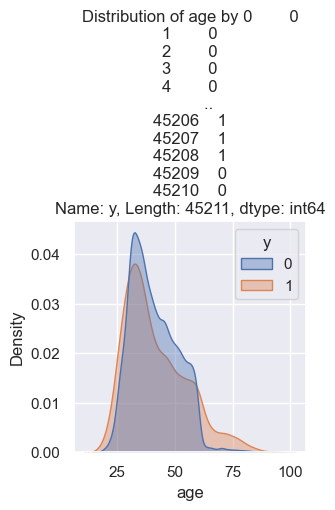

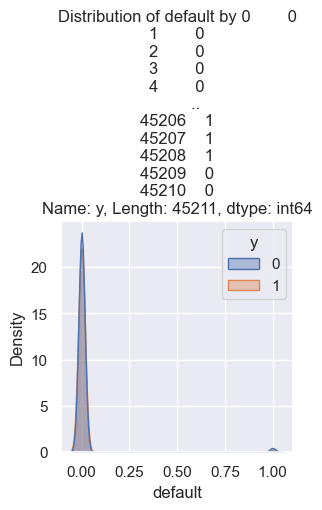

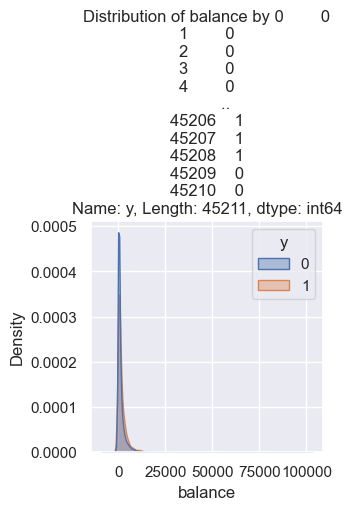

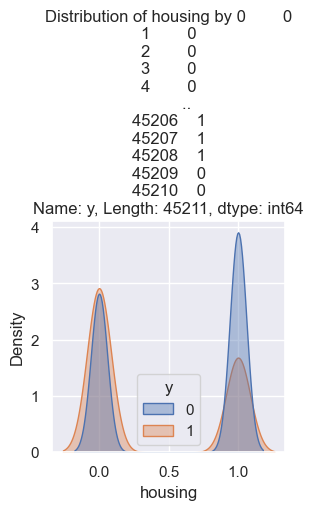

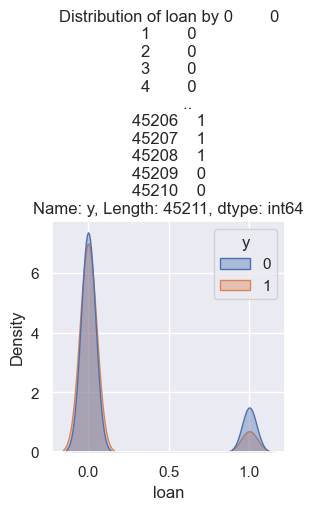

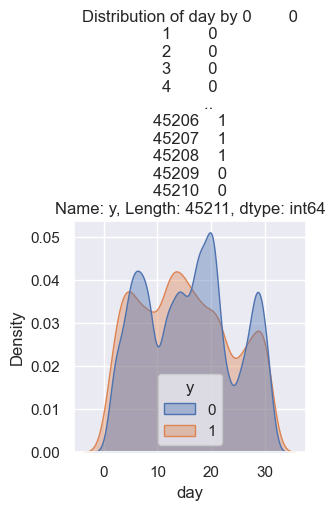

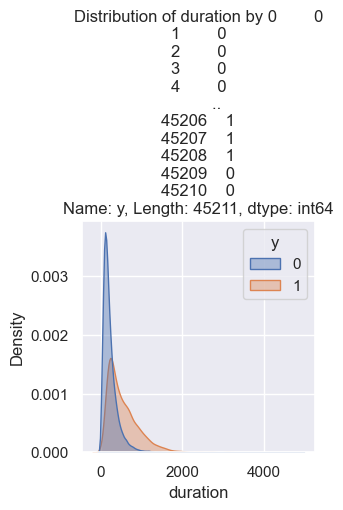

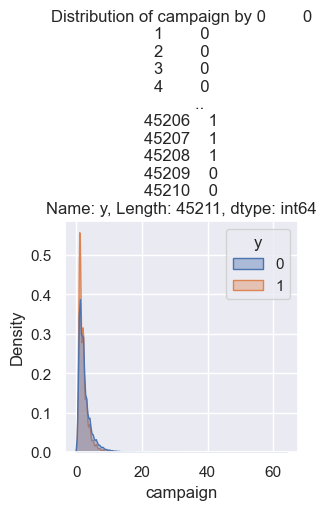

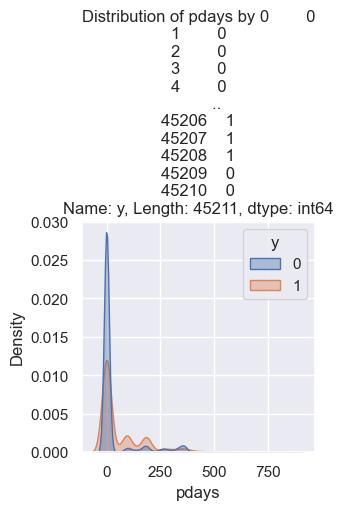

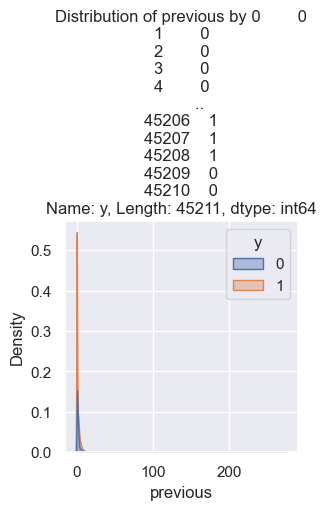

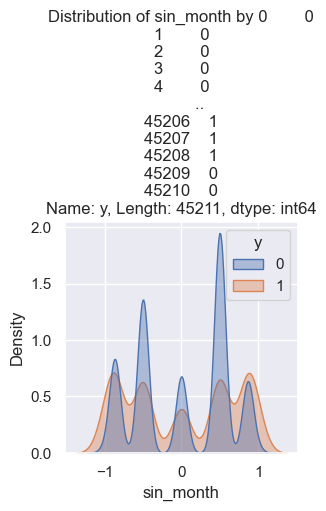

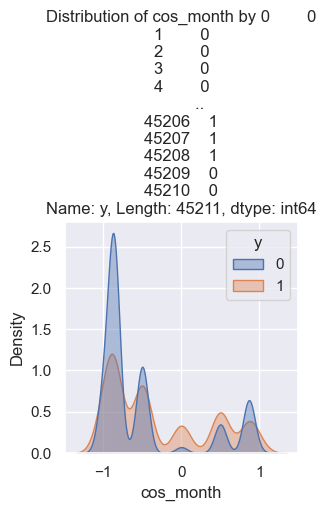

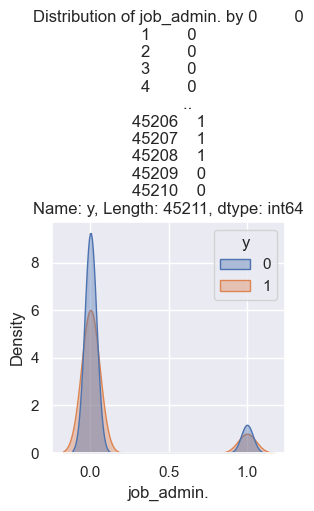

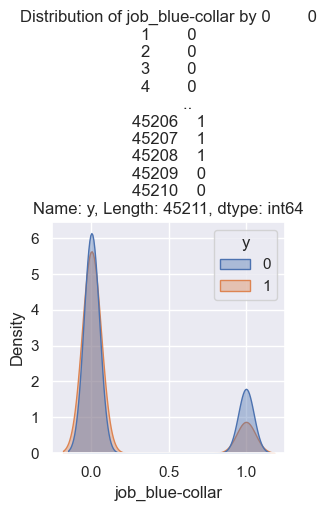

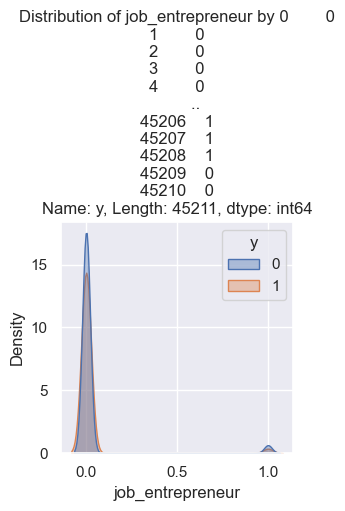

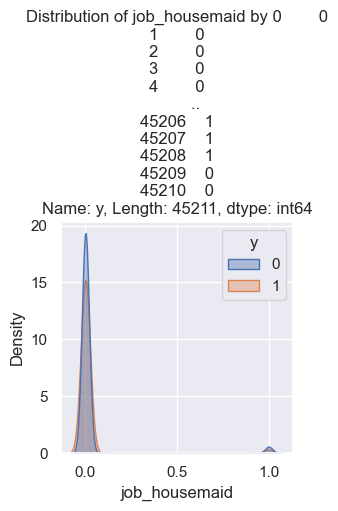

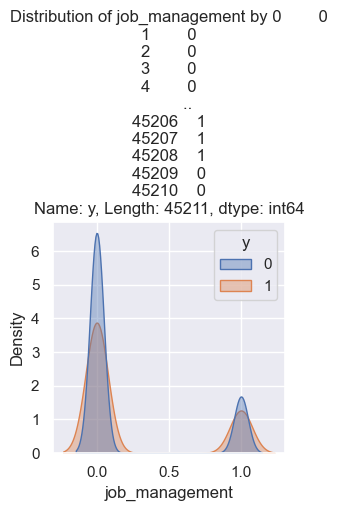

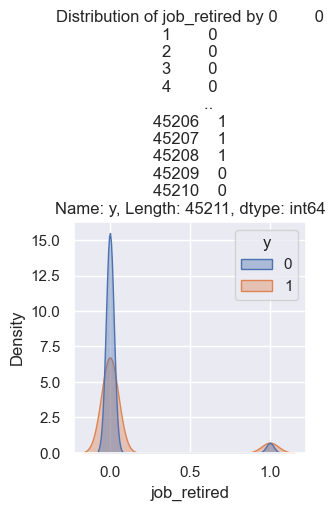

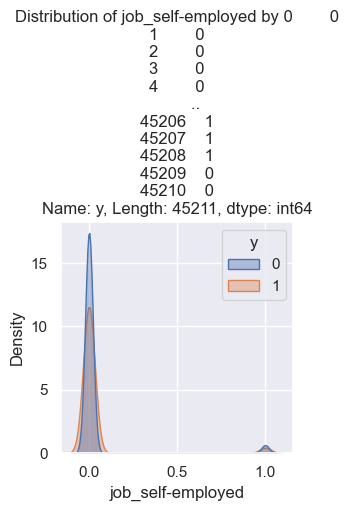

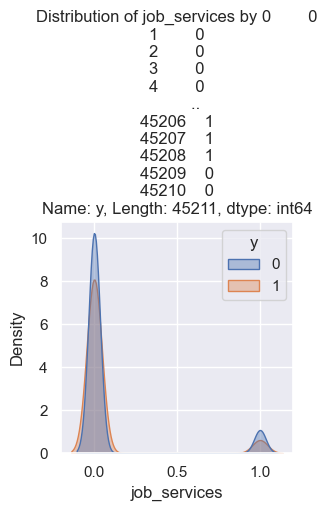

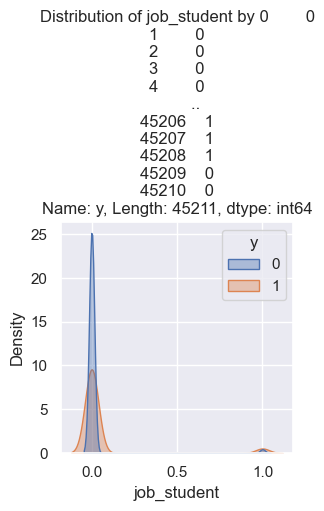

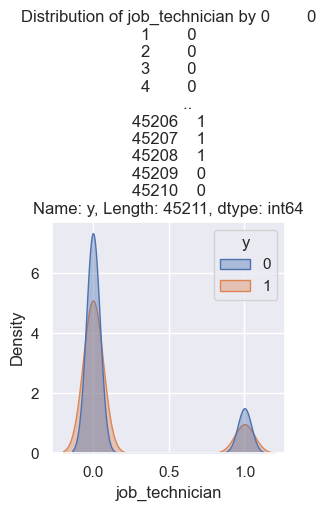

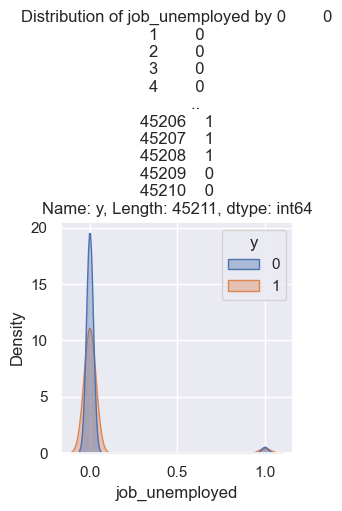

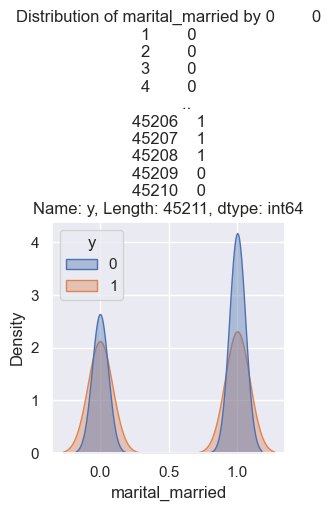

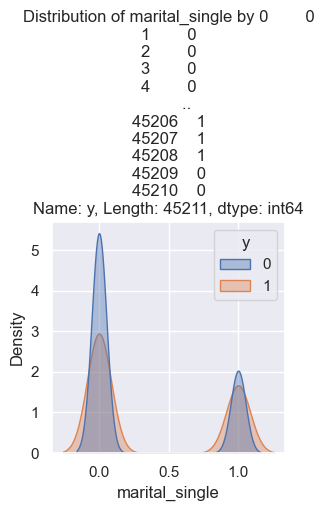

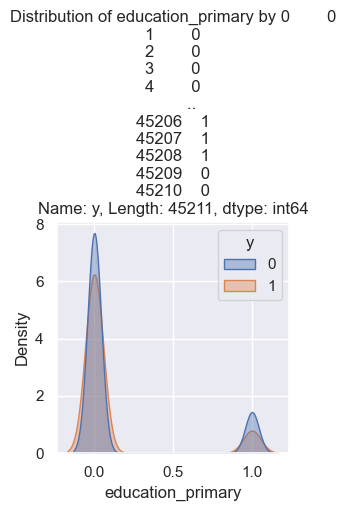

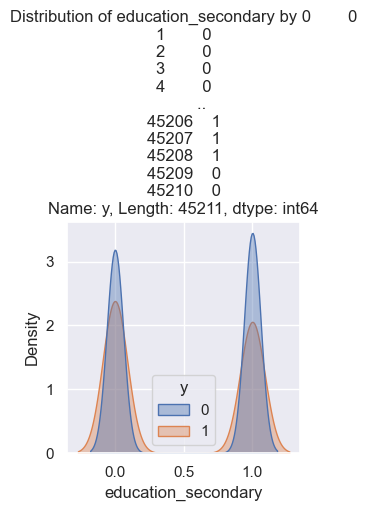

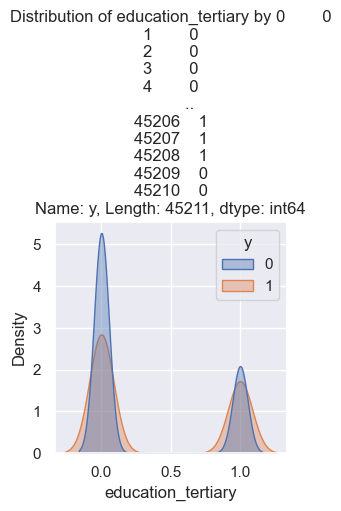

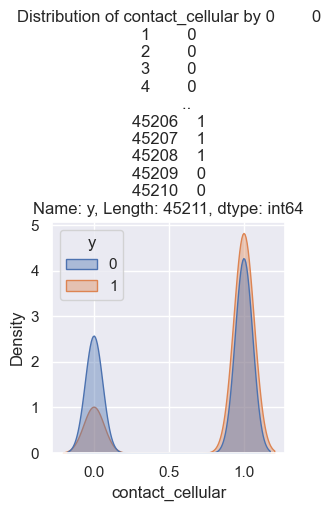

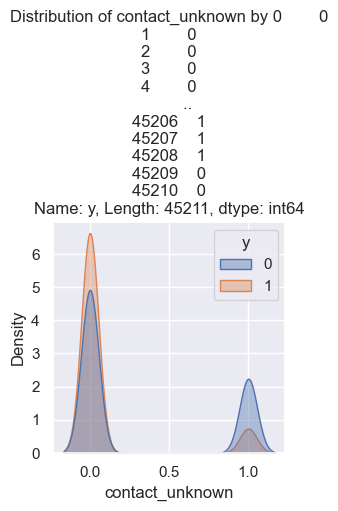

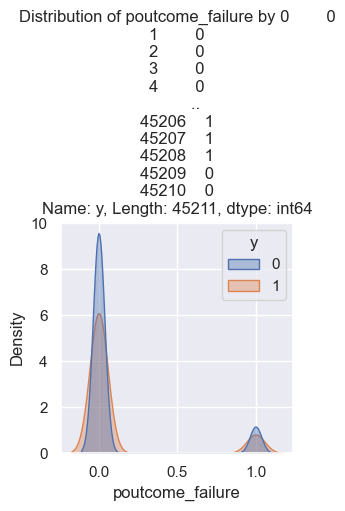

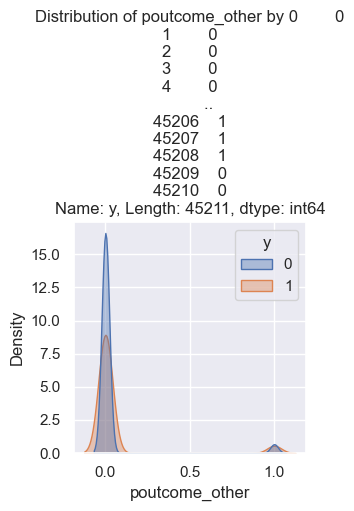

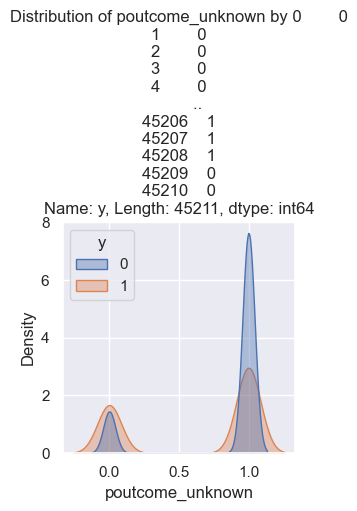

In [15]:
plot_distributions(X, target_col=y)

In [16]:
df_capped = cap_to_99(X)
df_capped.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,marital_married,marital_single,education_primary,education_secondary,education_tertiary,contact_cellular,contact_unknown,poutcome_failure,poutcome_other,poutcome_unknown
0,58,0,2143.0,1,0,5,261,1,-1,0.0,...,1,0,0,0,1,0,1,0,0,1
1,44,0,29.0,1,0,5,151,1,-1,0.0,...,0,1,0,1,0,0,1,0,0,1
2,33,0,2.0,1,1,5,76,1,-1,0.0,...,1,0,0,1,0,0,1,0,0,1
3,47,0,1506.0,1,0,5,92,1,-1,0.0,...,1,0,0,0,0,0,1,0,0,1
4,33,0,1.0,0,0,5,198,1,-1,0.0,...,0,1,0,0,0,0,1,0,0,1


## 2.3 After

In [17]:
display(df_capped.describe().T)

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.873571,10.410365,18.0,33.000000,3.900000e+01,48.0,71.000000
default,45211.0,0.018027,0.133049,0.0,0.000000,0.000000e+00,0.0,1.000000
balance,45211.0,1274.153452,2253.923733,-8019.0,72.000000,4.480000e+02,1428.0,13164.900000
housing,45211.0,0.555838,0.496878,0.0,0.000000,1.000000e+00,1.0,1.000000
loan,45211.0,0.160226,0.366820,0.0,0.000000,0.000000e+00,0.0,1.000000
day,45211.0,15.806419,8.322476,1.0,8.000000,1.600000e+01,21.0,31.000000
duration,45211.0,254.344385,234.812578,0.0,103.000000,1.800000e+02,319.0,1269.000000
campaign,45211.0,2.691403,2.585740,1.0,1.000000,2.000000e+00,3.0,16.000000
pdays,45211.0,39.313884,96.035004,-1.0,-1.000000,-1.000000e+00,-1.0,370.000000
previous,45211.0,0.524689,1.457817,0.0,0.000000,0.000000e+00,0.0,8.900000


# 3. After Plots

In [18]:
X = df_capped

In [19]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

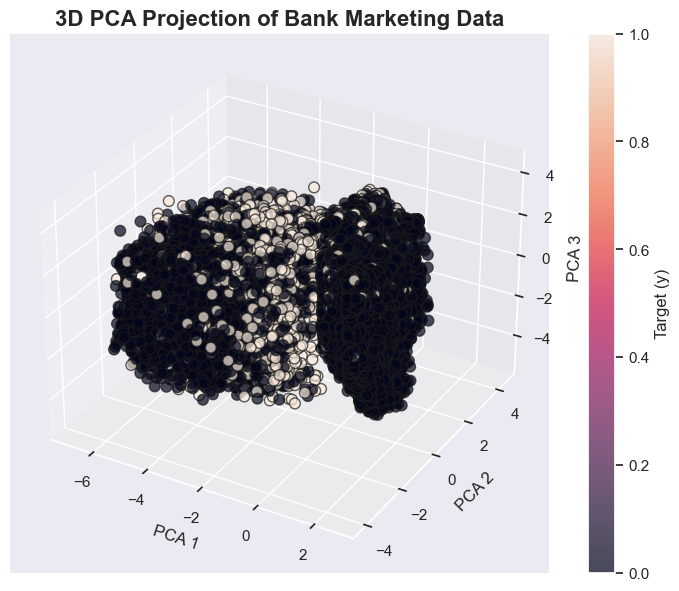

In [20]:
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    X_pca_3d[:,0], X_pca_3d[:,1], X_pca_3d[:,2], 
    c=y,  alpha=0.7, s=60, edgecolor="k"
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("3D PCA Projection of Bank Marketing Data", fontsize=16, weight="bold")
fig.colorbar(sc, ax=ax, label="Target (y)")
plt.show()

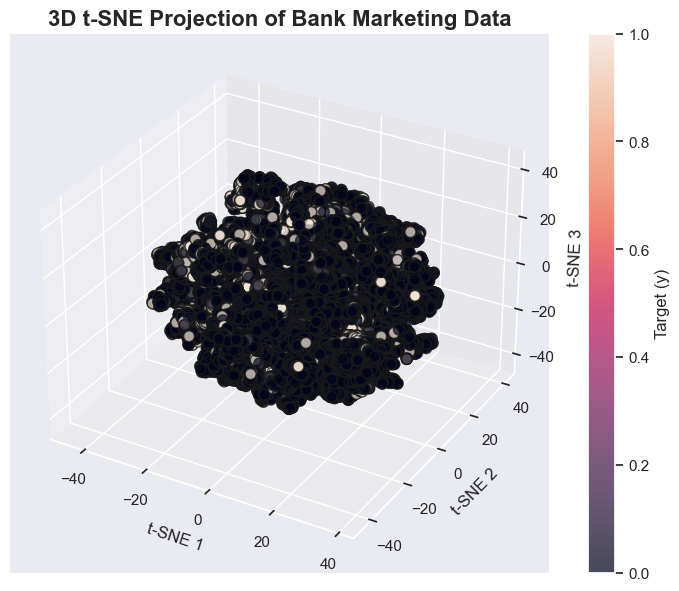

In [21]:
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30)
X_tsne_3d = tsne_3d.fit_transform(X)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    X_tsne_3d[:,0], X_tsne_3d[:,1], X_tsne_3d[:,2],
    c=y, alpha=0.7, s=60, edgecolor="k"
)

ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
ax.set_title("3D t-SNE Projection of Bank Marketing Data", fontsize=16, weight="bold")
fig.colorbar(sc, ax=ax, label="Target (y)")
plt.show()


# 4. Save

In [22]:
df_capped.to_csv(capped_file_path, index=False)
y.to_csv(target_file_path, index=False)


# END